# Running models on variations of MATseq dataset


14-03-2025


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropDuplicateFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import parallel_backend

In [13]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 400)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

In [14]:
custom_palette_6 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
]

In [15]:
p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year
RESULTS_PATH = p / f"{date}_output"
print(RESULTS_PATH)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = RESULTS_PATH / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def save_csv(table, table_name):
    """Save table in csv."""
    path = RESULTS_PATH / f"{table_name}.csv"
    table.to_csv(path)

/home/t.afanasyeva/MAT_rnaseq/250315_output


In [16]:
def get_confusion_matrix(test_pred, y_test, name):
    fig, ax = plt.subplots(figsize=(8, 8))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        test_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        values_format=".0%",
    )

    ax.set_title(f"Confusion Matrix {name}")
    plt.tight_layout()
    save_fig(f"Confusion_Matrix_{name}")
    plt.show()

In [17]:
class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000, axis=1)
        return X


en = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=42)

pipe = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("select_k_best", SelectKBest(chi2, k=1000)),
        ("select_forest", SelectFromModel(en, threshold=0.001, max_features=250)),
        ("standard_scale", StandardScaler()),
    ]
)
le = LabelEncoder()

In [18]:
from sklearn import set_config
from sklearn.utils import estimator_html_repr
import html2image

set_config(display="diagram")
set_config(display="diagram")
html_repr = estimator_html_repr(pipe)

# Save the HTML representation to a file
with open(RESULTS_PATH / "pipeline_diagram.html", "w") as f:
    f.write(html_repr)

In [ ]:
file_path_multiindex = p / "resources/250114_training_multindex_68_7128.csv"
data_wi = pd.read_csv(file_path_multiindex, index_col=[0, 1])

In [ ]:
# Read the CSV file
il6_readouts_path = p / "resources/240319_il6_readouts.csv"
il6_readouts = pd.read_csv(il6_readouts_path, index_col=0, sep=";")
il6_readouts

In [ ]:
# Filter the samples with the same index as data_wi
filtered_il6_readouts = il6_readouts[
    il6_readouts["sample_name"].isin(data_wi.index.get_level_values(0))
]
filtered_il6_readouts.drop_duplicates(subset="sample_name", inplace=True)
filtered_il6_readouts.set_index("sample_name", inplace=True)
filtered_il6_readouts.to_csv(RESULTS_PATH / "filtered_il6_readouts.csv")
filtered_il6_readouts.to_excel(RESULTS_PATH / "filtered_il6_readouts.xlsx")
print(filtered_il6_readouts)

/tmp/ipykernel_1281041/2859329741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_il6_readouts.drop_duplicates(subset='sample_name', inplace=True)


                           sample_id  IL6_protein_expression_3,5hours  \
sample_name                                                             
BA042_7128_IMDM_1     104741-001-004                              4.0   
BA042_7128_IMDM_2     104741-001-005                             12.0   
BA042_7128_IMDM_3     104741-001-006                              9.0   
BA042_7128_LPS_5      104741-001-007                            317.0   
BA042_7128_LPS_6      104741-001-008                            376.0   
BA042_7128_LPS_8      104741-001-009                            369.0   
BA042_7128_Fla-PA_17  104741-001-016                            300.0   
BA042_7128_Fla-PA_18  104741-001-017                            275.0   
BA042_7128_Fla-PA_20  104741-001-018                            282.0   
MD219_7128_IMDM_1     105659-001-073                              9.0   
MD219_7128_LPS_1      105659-001-074                            332.0   
MD219_7128_Fla-PA_1   105659-001-078               

In [ ]:
labels = data_wi.index.get_level_values("label").to_numpy()
labels = np.where(labels == "IMDM", "negative_control", labels)
data = data_wi.copy()
data.reset_index(drop=True, inplace=True)

In [62]:
processed_data = pipe.fit_transform(data, labels)
labels_int = le.fit_transform(labels)

## PCA before Feature selection

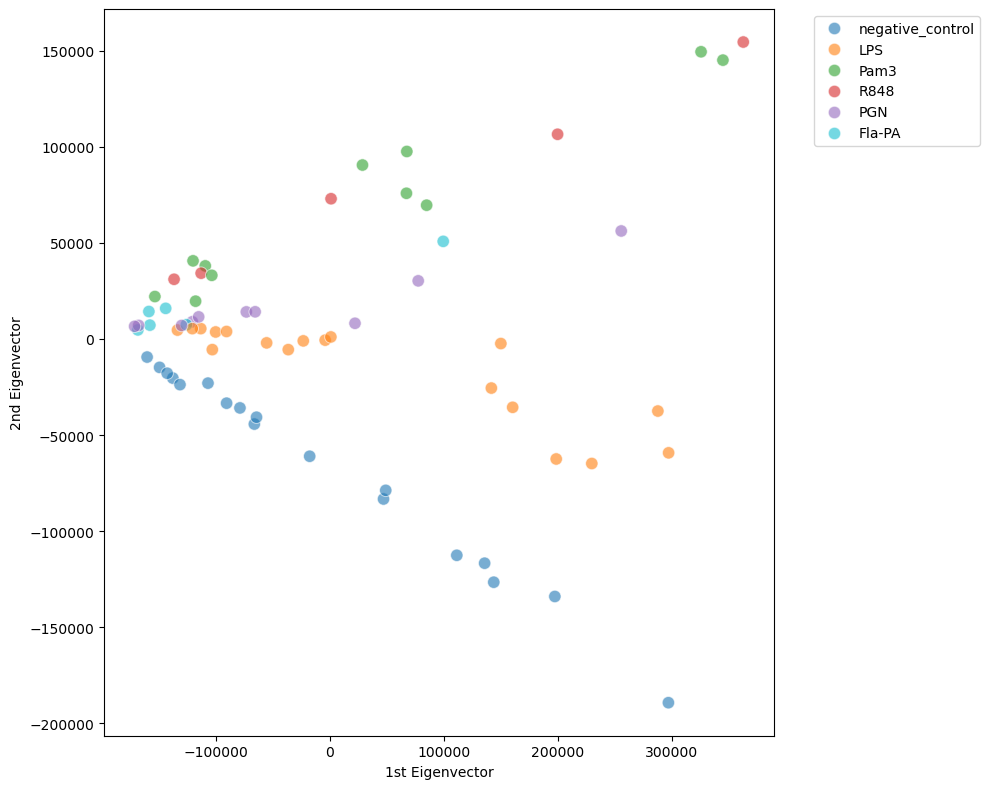

In [63]:
X_reduced = PCA(n_components=2).fit_transform(data)

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels,
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)
# texts = [
#     ax.text(
#         X_reduced[:, 0][i],
#         X_reduced[:, 1][i],
#         labels[i],
#         ha="left",
#         va="bottom",
#         alpha=0.8,
#     )
#     for i in range(len(X_reduced))
# ]

# adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_before_feature_selection")
plt.show()

## PCA after feature selection

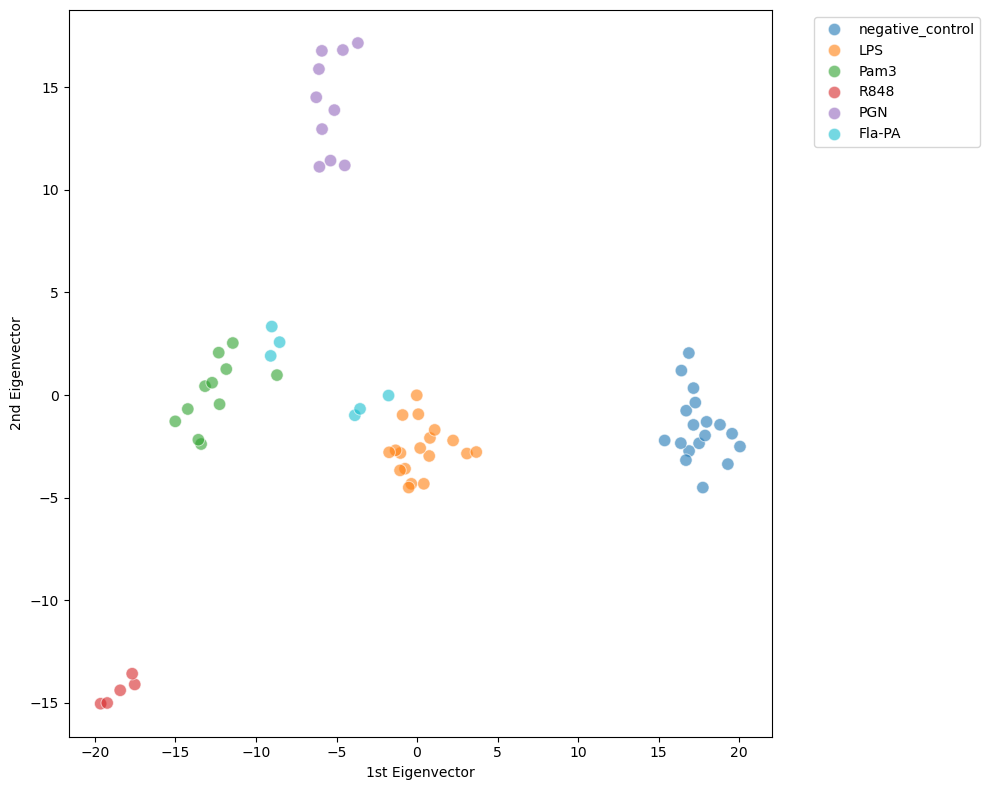

In [64]:
# colors = [
#     custom_palette_6[label % len(custom_palette_6)] for label in labels_int
# ]

X_reduced = PCA(n_components=2).fit_transform(processed_data)

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels,
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_after_feature_selection")
plt.show()

In [85]:
random_state = np.random.RandomState(42)

svc = SVC(
    kernel="linear", probability=False, class_weight=None, random_state=random_state
)
svc = CalibratedClassifierCV(svc)
sgd = SGDClassifier(
    loss="modified_huber", early_stopping=True, random_state=random_state
)
rfc = RandomForestClassifier(
    max_depth=5, n_estimators=500, random_state=random_state, class_weight=None
)
bst = XGBClassifier(objective="multi:softmax", random_state=random_state)

models = {
    "LinearSVC": svc,
    "SGDClassifier": sgd,
    "RandomForestClassifier": rfc,
    "XGBClassifier": bst,
}

In [66]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro") -> float:
    """Returns averaged auc per class"""
    unique_classes = set(y_test)
    roc_auc_dict = {}

    for tested_class in unique_classes:
        other_classes = [x for x in unique_classes if x != tested_class]

        # Marking the current class as 1 and all other classes as 0
        binary_y_test = [0 if x in other_classes else 1 for x in y_test]
        binary_y_pred = [0 if x in other_classes else 1 for x in y_pred]

        roc_auc = roc_auc_score(binary_y_test, binary_y_pred, average=average)

        roc_auc_dict[tested_class] = roc_auc

    return sum(roc_auc_dict.values()) / len(roc_auc_dict.values())


def make_score(y_test, y_pred) -> zip:
    accuracy, precision, recall, f1, roc_auc = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro", zero_division=np.nan),
        recall_score(y_test, y_pred, average="macro", zero_division=np.nan),
        f1_score(y_test, y_pred, average="macro", zero_division=np.nan),
        multiclass_roc_auc_score(y_test, y_pred),
    )

    score_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    return zip(score_names, (accuracy, precision, recall, f1, roc_auc))

1. Run with all features
2. Run with randomly selected 250 genes
3. Run with 250 genes post feature selection
4. Run with 250 + DE Genes

In [67]:
random_250_data = data.sample(n=250, axis=1, random_state=random_state)

In [68]:
de_genes_file_path = p / "250314_output" / "de_genes.txt"

with open(de_genes_file_path, "r") as file:
    de_genes = file.read().splitlines()
de_genes = list(set(de_genes))
print(len(data_wi.columns))
print(len(de_genes))
print(len(data_wi[de_genes].columns))

fs_and_de_data = data_wi[de_genes]
fs_and_de_data.reset_index(drop=True, inplace=True)

47698
554
554


In [69]:
dfs = {
    "all features": data,
    "randomly selected 250": random_250_data,
    "feature selection 250": processed_data,
    "feature selection and differential expressed 554": fs_and_de_data,
}

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)

In [71]:
# results = []
# with parallel_backend("threading", n_jobs=42):
#     for name_df, df in dfs.items():
#         print(f"Processing {name_df}")
#         X, y = sm.fit_resample(df, labels)
#         if not isinstance(X, np.ndarray):
#             X = X.to_numpy()

#         y = le.fit_transform(y)

#         print("Finished SMOTE")

#         CV = 5
#         sss = StratifiedShuffleSplit(
#             n_splits=CV, test_size=0.2, random_state=random_state
#         )

#         for model_name, model in tqdm(models.items()):
#             print(f"Processing {model_name}")
#             start_time = time.time()
#             for fold_index, (train_index, test_index) in enumerate(sss.split(X, y)):
#                 X_train, X_test = X[train_index], X[test_index]
#                 y_train, y_test = y[train_index], y[test_index]

#                 model.fit(X_train, y_train)
#                 y_pred = model.predict(X_test)

#                 total_time = time.time() - start_time

#                 for score_name, score_value in make_score(y_test, y_pred):
#                     results.append(
#                         {
#                             "fold": fold_index + 1,
#                             "model": model_name,
#                             "data": name_df,
#                             "score_name": score_name,
#                             "score_value": score_value,
#                             "run_time": total_time,
#                         }
#                     )

#                 y_pred = le.inverse_transform(y_pred)
#                 y_test = le.inverse_transform(y_test)
#                 get_confusion_matrix(y_pred, y_test, model_name)
#                 print(classification_report(y_pred, y_test))

In [72]:
# scores = pd.DataFrame(results)

# # Save as CSV
# scores.to_csv(RESULTS_PATH / "models_scores_comparison.csv", index=False)

# # Save as Excel
# scores.to_excel(RESULTS_PATH / "models_scores_comparison.xlsx", index=False)

# scores_grouped = (
#     scores.groupby(["data", "model", "score_name"])
#     .agg({"score_value": ["mean", "std"], "run_time": ["mean", "std"]})
#     .round(3)
# )
# scores_grouped
# # Save as CSV
# scores_grouped.to_csv(RESULTS_PATH / "scores_grouped.csv")

# # Save as Excel
# scores_grouped.to_excel(RESULTS_PATH / "scores_grouped.xlsx")

In [73]:
# df = pd.read_csv("/home/t.afanasyeva/MAT_rnaseq/250315_output/scores_grouped.csv")
# df["score_value"] = pd.to_numeric(df["score_value"], errors="coerce")
# df["score_value.1"] = pd.to_numeric(df["score_value.1"], errors="coerce")
# df["run_time"] = pd.to_numeric(df["run_time"], errors="coerce")
# df["run_time.1"] = pd.to_numeric(df["run_time.1"], errors="coerce")

# for i in range(len(df)):
#     if (
#         i > 0
#         and not pd.isna(df.loc[i, "score_value"])
#         and not pd.isna(df.loc[i, "score_value.1"])
#     ):
#         df.loc[i, "mean_std"] = (
#             str(df.loc[i, "score_value"].round(2))
#             + " ± "
#             + str(df.loc[i, "score_value.1"].round(2))
#         )

# for i in range(len(df)):
#     if (
#         i > 0
#         and not pd.isna(df.loc[i, "run_time"])
#         and not pd.isna(df.loc[i, "run_time.1"])
#     ):
#         df.loc[i, "mean_std_run_time"] = (
#             str(int(df.loc[i, "run_time"])) + " ± " + str(int(df.loc[i, "run_time.1"]))
#         )

# df.to_csv(
#     "/home/t.afanasyeva/MAT_rnaseq/250315_output/scores_grouped_merged_columns.csv",
#     index=False,
# )
# df.to_excel(
#     "/home/t.afanasyeva/MAT_rnaseq/250315_output/scores_grouped_merged_columns.xlsx",
#     index=False,
# )

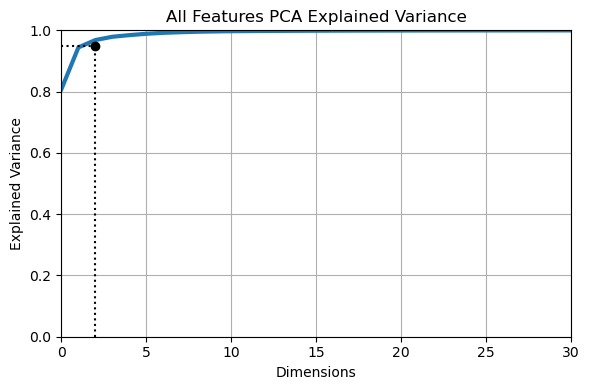

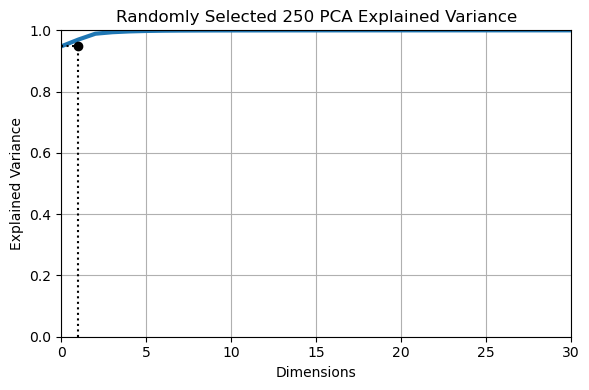

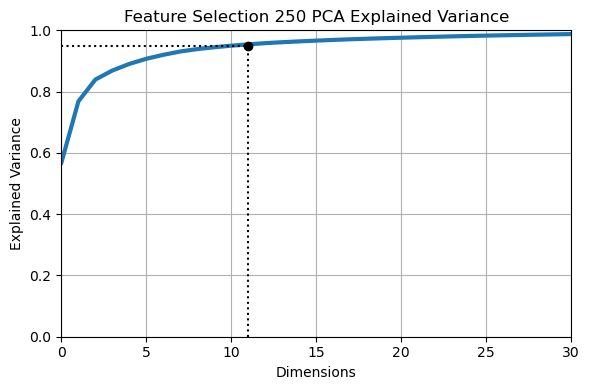

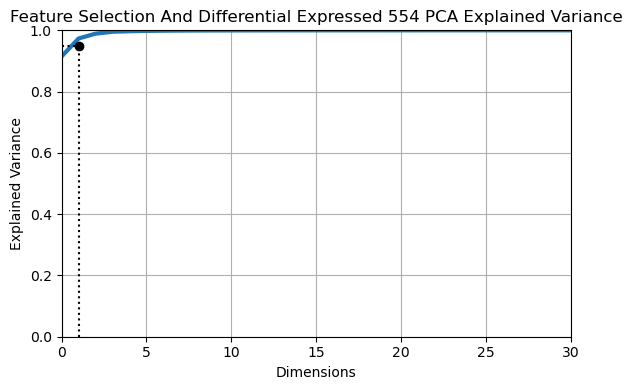

In [74]:
for name, df in dfs.items():

    pca = PCA()
    pca.fit(df)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95)

    plt.figure(figsize=(6, 4))
    plt.plot(cumsum, linewidth=3)
    plt.axis([0, 30, 0, 1])
    plt.title(
        " ".join([word.capitalize() for word in name.split()])
        + " PCA Explained Variance"
    )
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance")
    plt.plot([d, d], [0, 0.95], "k:")
    plt.plot([0, d], [0.95, 0.95], "k:")
    plt.plot(d, 0.95, "ko")

    plt.grid(True)
    save_fig(f"{name}_PCA_explained_variance")
    plt.show()

In [75]:
file_path_multiindex = p / "resources/250114_training_multindex_68_7128.csv"
data_wi = pd.read_csv(file_path_multiindex, index_col=[0, 1])
print(len(data_wi))

68


In [76]:
# Assuming 'LPS' and 'negative_control' are labels in the index
lps_sample = data_wi.loc[data_wi.index.get_level_values("label") == "LPS"].sample(
    n=1, random_state=random_state
)
negative_control_sample = data_wi.loc[
    data_wi.index.get_level_values("label") == "IMDM"
].sample(n=1, random_state=random_state)

data_wi = data_wi.drop(lps_sample.index)
data_wi = data_wi.drop(negative_control_sample.index)

negative_control_sample.reset_index(drop=True, inplace=True)
lps_sample.reset_index(drop=True, inplace=True)

len(data_wi)

66

In [77]:
labels = data_wi.index.get_level_values("label").to_numpy()
labels = np.where(labels == "IMDM", "negative_control", labels)
data = data_wi.copy()
data.reset_index(drop=True, inplace=True)

labels_int = le.fit_transform(labels)
processed_data = pipe.fit_transform(data, labels)

In [78]:
processed_negative_control_sample = pipe.transform(negative_control_sample)
processed_lps_sample = pipe.transform(lps_sample)

In [ ]:
path = "/home/t.afanasyeva/MAT_rnaseq/resources/240826_245_samples.csv"
data_all = pd.read_csv(path, index_col="samples")
bacterial_data = data_all[data_all.index.str.contains("HKSA|HKEB")]
bacterial_data = bacterial_data.sort_index(
    key=lambda x: x.str.extract(r"(HKSA|HKEB)", expand=False)
)
bac_labels = bacterial_data.index.str.extract(r"(HKSA|HKEB)", expand=False).to_numpy()

In [80]:
bac_labels = np.where(bac_labels == "HKSA", "HK S.aureus", bac_labels)
bac_labels = np.where(bac_labels == "HKEB", "HK E.coli", bac_labels)
bacterial_data.reset_index(drop=True, inplace=True)
processed_bacterial_data = pipe.transform(bacterial_data)

In [ ]:
def make_probability_matrix(model_name, test_pred):
    plt.figure(figsize=(12, 8))

    g = sns.heatmap(test_pred, cmap="YlGnBu")
    g.set_title(f"{model_name} Heat Killed Bacteria predictions", fontsize=15)
    g.set_xlabel("Reference", fontsize=15)
    g.set_ylabel("Sample", fontsize=15, labelpad=10)
    # heat.set_xticklabels(["Negative Control", "Positive Control", "Heat Killed Bacteria"], fontsize=12)
    plt.tight_layout()
    save_fig(f"{model_name}_Heat_Killed_Predictions")
    plt.show()

    return g

In [82]:
processed_bacterial_data.shape

(12, 250)

Finished SMOTE


  0%|          | 0/4 [00:00<?, ?it/s]

Processing LinearSVC
[[0.01129069 0.1865023  0.06485546 0.00175141 0.0355836  0.70001653]]


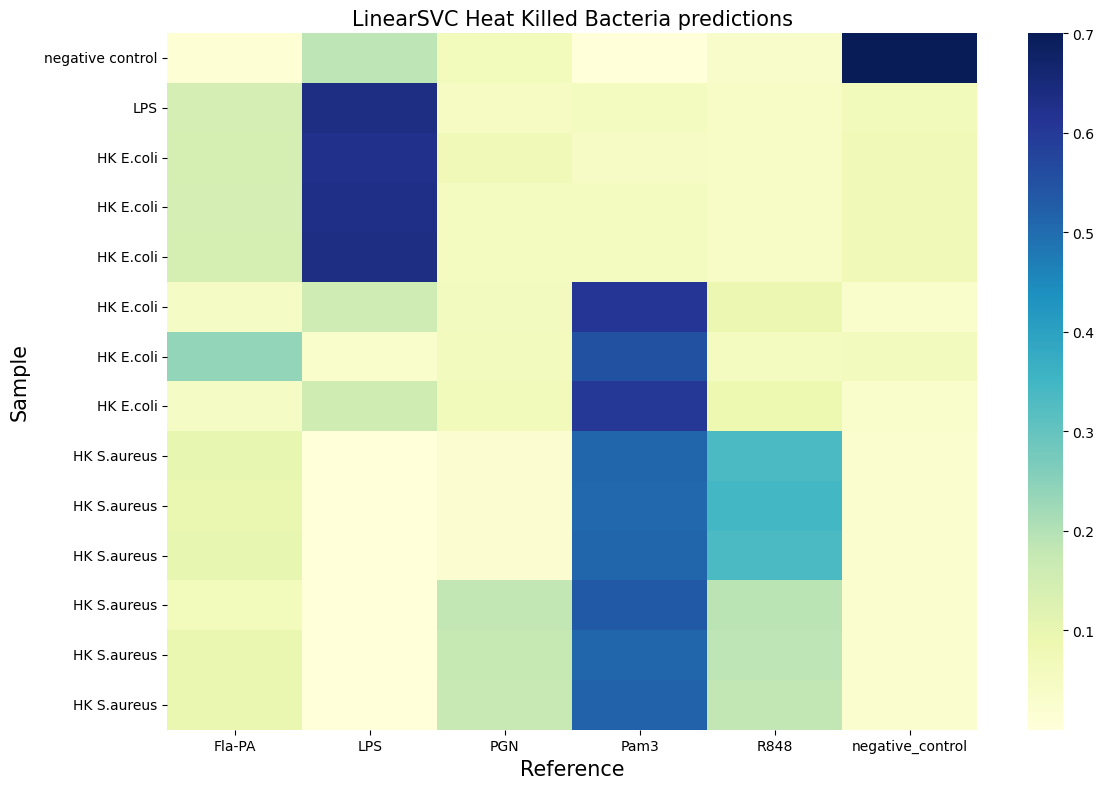

 25%|██▌       | 1/4 [00:00<00:02,  1.23it/s]

Processing SGDClassifier
[[0. 0. 0. 0. 0. 1.]]


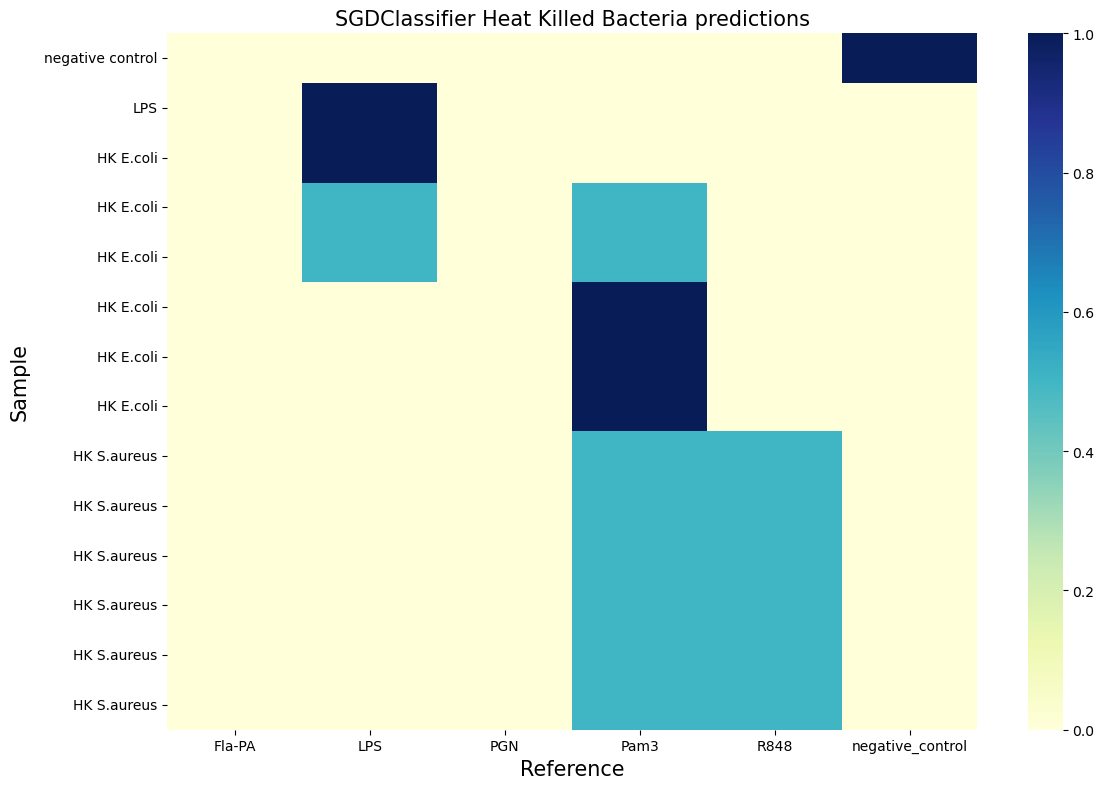

 50%|█████     | 2/4 [00:01<00:01,  1.25it/s]

Processing RandomForestClassifier
[[1.53846154e-04 6.15384615e-03 2.14285714e-03 3.07692308e-04
  6.00000000e-03 9.85241758e-01]]


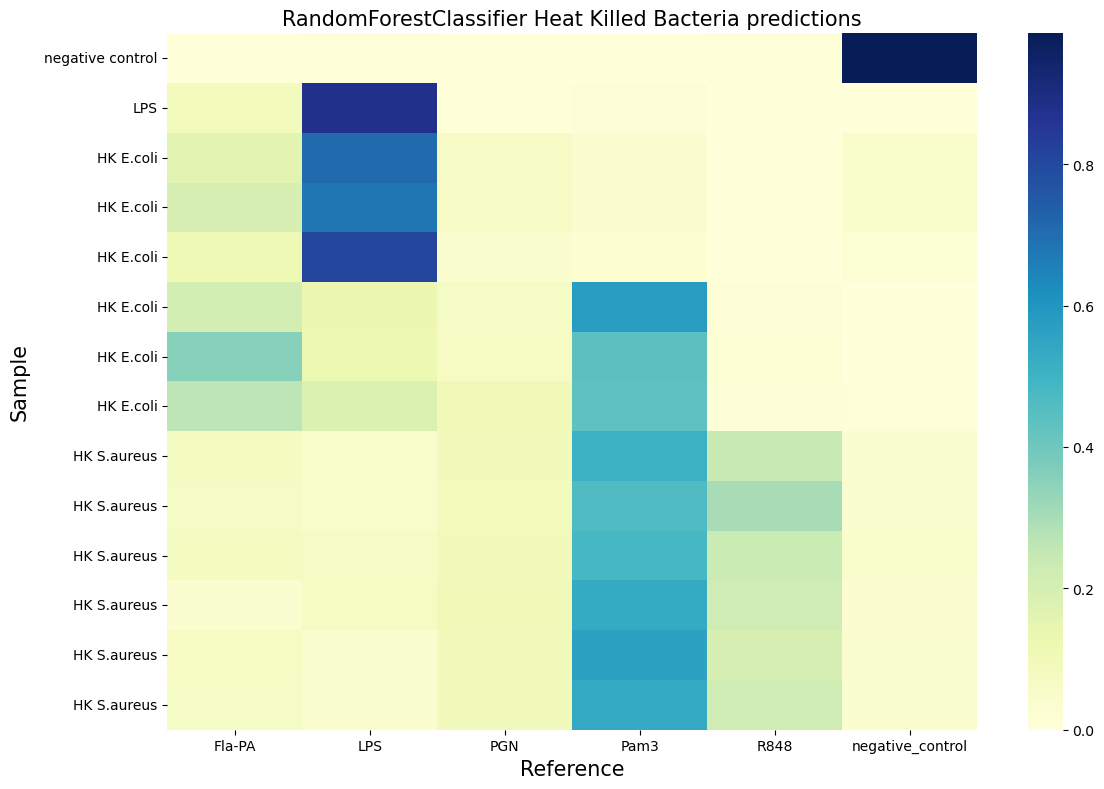

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


In [86]:
results = []
with parallel_backend("threading", n_jobs=42):
    X, y = sm.fit_resample(processed_data, labels_int)
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()

    print("Finished SMOTE")
    for model_name, model in tqdm(models.items()):
        if model_name == "XGBClassifier":
            continue
        print(f"Processing {model_name}")
        model.fit(X, y)

        y_pred_negative_control = model.predict_proba(processed_negative_control_sample)
        y_pred_positive_control = model.predict_proba(processed_lps_sample)
        y_pred_bac = model.predict_proba(processed_bacterial_data)

        test_pred = pd.DataFrame(
            np.vstack([y_pred_negative_control, y_pred_positive_control, y_pred_bac]),
            columns=le.classes_,
            index=["negative control", "LPS", *bac_labels],
        )

        # y_pred = np.vstack([ y_pred_negative_control, y_pred_positive_control])
        print(y_pred_negative_control)
        make_probability_matrix(model_name, test_pred)

/tmp/ipykernel_1274856/1068700299.py:14: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(


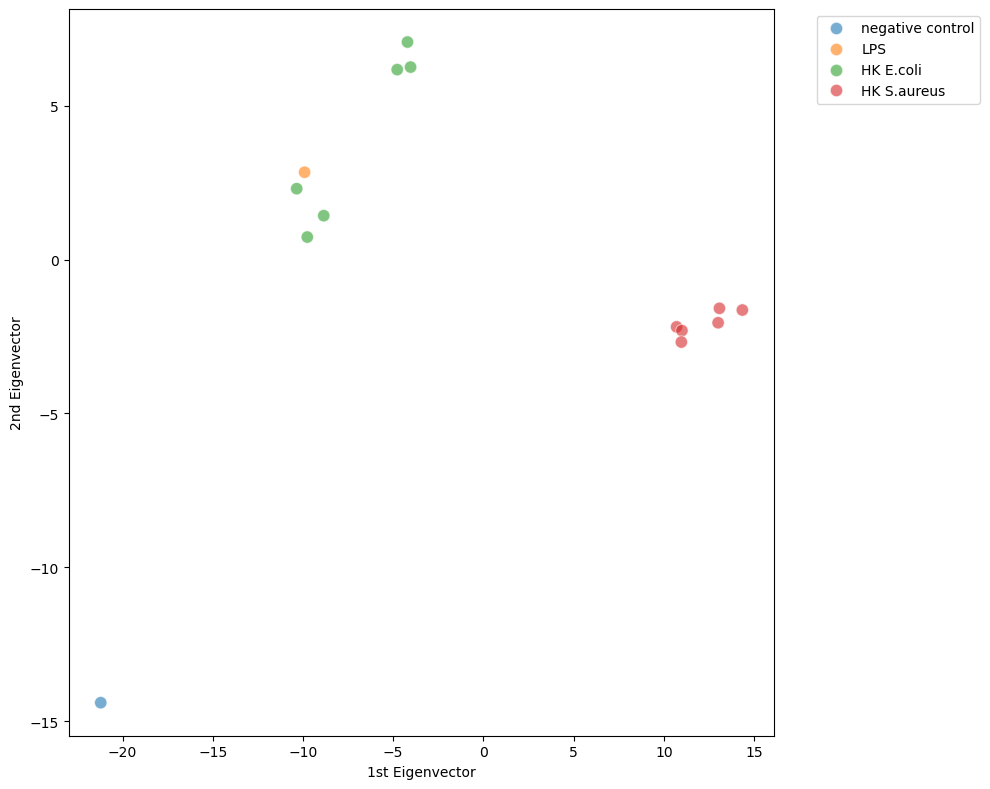

In [38]:
labels_merged = np.concatenate([["negative control", "LPS"], bac_labels])
data_merged = np.vstack(
    [processed_negative_control_sample, processed_lps_sample, processed_bacterial_data]
)
X_reduced = PCA(n_components=2).fit_transform(data_merged)

custom_palette_4 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#e377c2",  # Pink
    "#bcbd22",  # Yellow-Green
]

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels_merged,
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_wbacterial_data")
plt.show()

In [42]:
len(processed_data)

66

In [49]:
file_path_multiindex = p / "resources/250114_training_multindex_68_7128.csv"
data_wi = pd.read_csv(file_path_multiindex, index_col=[0, 1])
labels = data_wi.index.get_level_values("label").to_numpy()
labels = np.where(labels == "IMDM", "negative_control", labels)
data = data_wi.copy()
data.reset_index(drop=True, inplace=True)
processed_data = pipe.fit_transform(data, labels)
print(len(data_wi))

68


In [88]:
labels_merged_all = np.concatenate([labels, bac_labels])
data_merged_all = np.vstack([processed_data, processed_bacterial_data])

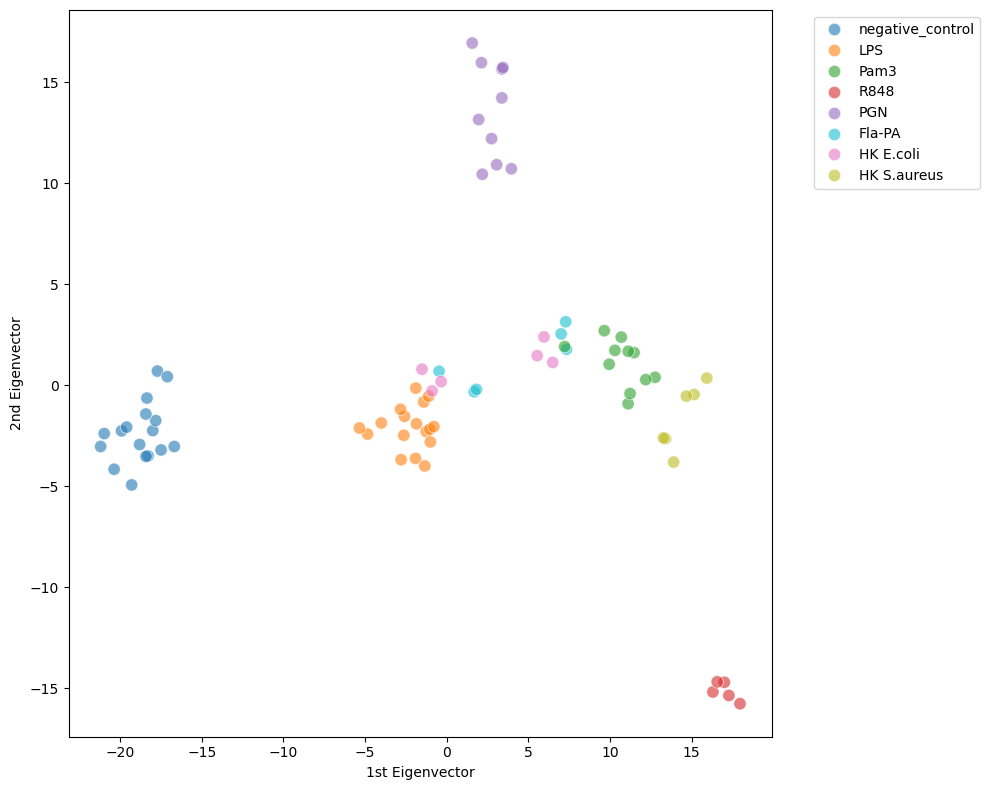

In [89]:
X_reduced = PCA(n_components=2).fit_transform(data_merged_all)


custom_palette_8 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
    "#e377c2",  # Pink
    "#bcbd22",  # Yellow-Green
]

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels_merged_all,
    s=80,
    alpha=0.6,
    palette=custom_palette_8,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_wbacterial_data_all")
plt.show()